In [57]:
import os
import warnings
warnings.filterwarnings('ignore')
print(os.listdir("/kaggle/input/resnest50/pytorch/default/1"))

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

['resnet50-0676ba61.pth']


In [58]:
MEAN = (0.485, 0.456, 0.406)
STD = (0.229, 0.224, 0.225)
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS_FROZEN = 4  # Epochs for frozen backbone training
NUM_EPOCHS_FINETUNE = 15  # Epochs for fine-tuning
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.6.0+cu124


In [59]:
DATA_DIR = '/kaggle/input/a2-dataset/Assignment 2 Dataset'
train_csv_path = f"{DATA_DIR}/train.csv"
test_csv_path = f"{DATA_DIR}/test.csv"

print(f"\nLoading CSV files from {DATA_DIR}...")
full_dataset = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

print("\nTrain CSV head:")
print(full_dataset.head())
print(f"\nTrain dataset shape: {full_dataset.shape}")

print("\nTest CSV head:")
print(test_df.head())
print(f"Test dataset shape: {test_df.shape}")

# Determine number of classes
num_classes = full_dataset["label"].nunique()
print(f"\n✓ Number of classes: {num_classes}")

# Check class distribution
print("\nClass distribution in training set:")
class_counts = full_dataset['label'].value_counts().sort_index()
print(f"Min samples per class: {class_counts.min()}")
print(f"Max samples per class: {class_counts.max()}")
print(f"Mean samples per class: {class_counts.mean():.2f}")


Loading CSV files from /kaggle/input/a2-dataset/Assignment 2 Dataset...

Train CSV head:
            id  label
0  train/1.jpg      3
1  train/2.jpg     80
2  train/3.jpg     95
3  train/4.jpg     78
4  train/5.jpg     85

Train dataset shape: (4135, 2)

Test CSV head:
              id
0  test/4136.jpg
1  test/4137.jpg
2  test/4138.jpg
3  test/4139.jpg
4  test/4140.jpg
Test dataset shape: (4080, 1)

✓ Number of classes: 100

Class distribution in training set:
Min samples per class: 28
Max samples per class: 49
Mean samples per class: 41.35


In [60]:
class CarDataset(Dataset): #changed it a bit
    """
    Custom Dataset class for car images
    Handles both training data (with labels) and test data (without labels)
    """
    def __init__(self, df, data_dir='.', transform=None):
        self.df = df.reset_index(drop=True)
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = row["id"]  # e.g., "train/1.jpg" or "test/4136.jpg"

        # Construct full path
        img_path = os.path.join(self.data_dir, img_id)

        # Load label if it exists (train.csv has 'label', test.csv doesn't)
        label = int(row["label"]) if "label" in row else -1

        # Load and convert image
        image = Image.open(img_path).convert("RGB")

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
print("\n" + "="*80)
print("TECHNIQUE 1: Enhanced Data Augmentation")
print("="*80)

# Heavy augmentation for training (prevents overfitting)
train_transform_heavy = transforms.Compose([
    transforms.Resize((IMG_SIZE + 32, IMG_SIZE + 32)),  # Resize larger first
    transforms.RandomCrop(IMG_SIZE),  # Random crop for better augmentation
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),  # Increased rotation from 15 to 20
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.15),  # Stronger color jitter
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), scale=(0.9, 1.1)),  # Added scale variation
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),  # Increased distortion
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.25), ratio=(0.3, 3.3))  # More aggressive random erasing
])

# No augmentation for validation and test
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

print("✓ Augmentation strategies defined:")
print("  - Training: Flip, Rotation(±15°), ColorJitter, Affine, Perspective, RandomErasing")
print("  - Validation/Test: No augmentation (clean images)")


TECHNIQUE 1: Enhanced Data Augmentation
✓ Augmentation strategies defined:
  - Training: Flip, Rotation(±15°), ColorJitter, Affine, Perspective, RandomErasing
  - Validation/Test: No augmentation (clean images)


In [ ]:
print("\n" + "="*80)
print("TECHNIQUE 2 & 3: Transfer Learning with Progressive Fine-tuning")
print("="*80)

def create_resnet50_model(num_classes, freeze_layers=True):
    """
    Create ResNet50 model for transfer learning

    Args:
        num_classes: Number of output classes
        freeze_layers: If True, freeze all layers except classifier

    Returns:
        model: ResNet50 model ready for training
    """
    print("\nCreating ResNet50 model...")
    WEIGHTS_PATH = "/kaggle/input/resnest50/pytorch/default/1/resnet50-0676ba61.pth"

    # 1. create bare resnet50 (no download)
    model = models.resnet50(weights=None)
    
    # 2. load pretrained weights from your uploaded file
    state_dict = torch.load(WEIGHTS_PATH, map_location=DEVICE)
    model.load_state_dict(state_dict)

    # Replace final fully connected layer
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.7),                    # Increased dropout to reduce overfitting
        nn.Linear(num_features, num_classes)
    )

    if freeze_layers:
        # Freeze all layers
        for param in model.parameters():
            param.requires_grad = False

        # Unfreeze only the classifier
        for param in model.fc.parameters():
            param.requires_grad = True

        print(" Model created with frozen backbone")
        print(f"  - Trainable params: Classifier only ({num_features} -> {num_classes})")
    else:
        print(" Model created with all layers trainable")

    return model

def unfreeze_last_layers(model):
    """
    Unfreeze layer3 and layer4 of ResNet50 for fine-tuning

    Args:
        model: ResNet50 model

    Returns:
        model: Model with unfrozen layers
    """
    print("\nUnfreezing last layers for fine-tuning...")

    # Unfreeze layer4 (last residual block)
    for param in model.layer4.parameters():
        param.requires_grad = True

    # Unfreeze layer3 (second-to-last residual block)
    for param in model.layer3.parameters():
        param.requires_grad = True

    print("✓ Unfroze layer3 and layer4 (last two residual blocks)")

    # Count trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"  - Trainable params: {trainable_params:,} / {total_params:,} ({100*trainable_params/total_params:.1f}%)")

    return model


TECHNIQUE 2 & 3: Transfer Learning with Progressive Fine-tuning


In [ ]:
def train_epoch(model, loader, criterion, optimizer, device, max_grad_norm=1.0):
    """Train model for one epoch with gradient clipping"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc='Training', leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'acc': f"{correct/total:.4f}"
        })

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    """Validate model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validation', leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer,
                scheduler, num_epochs, device, save_path='best_model.pt', title='Model', 
                early_stopping_patience=5):
    """
    Complete training pipeline with validation, checkpointing, and early stopping

    Args:
        early_stopping_patience: Number of epochs to wait before stopping if no improvement

    Returns:
        History of training: losses and accuracies
    """
    best_val_acc = 0.0
    best_val_loss = float('inf')
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    patience_counter = 0

    print(f"\nStarting training for: {title}")
    print("="*60)
    print(f"Early stopping patience: {early_stopping_patience} epochs")

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 50)

        # Training phase
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation phase
        val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
        print(f'Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}')

        # Save best model (based on validation accuracy)
        improved = False
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
            improved = True
            print(f'✓ New best model saved! (Val Acc: {best_val_acc:.4f})')
        elif val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            improved = True
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= early_stopping_patience:
            print(f'\n⚠ Early stopping triggered after {epoch+1} epochs')
            print(f'   No improvement for {early_stopping_patience} consecutive epochs')
            break

        # Learning rate scheduling
        if scheduler:
            old_lr = optimizer.param_groups[0]['lr']
            scheduler.step(val_loss)
            new_lr = optimizer.param_groups[0]['lr']
            if new_lr != old_lr:
                print(f'Learning rate reduced: {old_lr:.6f} -> {new_lr:.6f}')

    print(f"\n{'='*60}")
    print(f"Training complete for {title}")
    print(f"Best validation accuracy: {best_val_acc:.4f}")
    print(f"Best validation loss: {best_val_loss:.4f}")
    print(f"{'='*60}\n")

    return train_losses, train_accs, val_losses, val_accs

In [65]:
def plot_training_history(train_losses, train_accs, val_losses, val_accs, title=''):
    """Plot training and validation metrics"""
    epochs = range(1, len(train_losses) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Loss plot
    ax1.plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2, marker='o')
    ax1.plot(epochs, val_losses, 'r-', label='Val Loss', linewidth=2, marker='s')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title(f'{title} - Loss Curves', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # Accuracy plot
    ax2.plot(epochs, train_accs, 'b-', label='Train Acc', linewidth=2, marker='o')
    ax2.plot(epochs, val_accs, 'r-', label='Val Acc', linewidth=2, marker='s')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title(f'{title} - Accuracy Curves', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{title.replace(" ", "_")}_history.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Print final statistics
    print(f"\n{title} - Final Statistics:")
    print(f"  Final Train Loss: {train_losses[-1]:.4f} | Final Train Acc: {train_accs[-1]:.4f}")
    print(f"  Final Val Loss:   {val_losses[-1]:.4f} | Final Val Acc:   {val_accs[-1]:.4f}")
    print(f"  Best Val Acc:     {max(val_accs):.4f} (Epoch {val_accs.index(max(val_accs))+1})")
    print(f"  Overfitting Gap:  {(train_accs[-1] - val_accs[-1]):.4f}")

def plot_comparison(history1, history2):
    """Plot comparison between frozen and fine-tuned models"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Validation loss comparison
    ax1.plot(range(1, len(history1[2])+1), history1[2], 'b-', label='Stage 1: Frozen', linewidth=2, marker='o')
    ax1.plot(range(1, len(history2[2])+1), history2[2], 'r-', label='Stage 2: Fine-tuned', linewidth=2, marker='s')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Validation Loss', fontsize=12)
    ax1.set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # Validation accuracy comparison
    ax2.plot(range(1, len(history1[3])+1), history1[3], 'b-', label='Stage 1: Frozen', linewidth=2, marker='o')
    ax2.plot(range(1, len(history2[3])+1), history2[3], 'r-', label='Stage 2: Fine-tuned', linewidth=2, marker='s')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Validation Accuracy', fontsize=12)
    ax2.set_title('Validation Accuracy Comparison', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('stage_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\nComparison Summary:")
    print(f"  Stage 1 Best Val Acc: {max(history1[3]):.4f}")
    print(f"  Stage 2 Best Val Acc: {max(history2[3]):.4f}")
    print(f"  Improvement: {(max(history2[3]) - max(history1[3])):.4f} ({100*(max(history2[3]) - max(history1[3])):.2f}%)")

In [66]:
print("\n" + "="*80)
print("Creating Train/Validation Split and DataLoaders")
print("="*80)

# Split with stratification to maintain class balance
train_df, val_df = train_test_split(
    full_dataset,
    test_size=0.2,
    random_state=42,
    stratify=full_dataset['label']
)

print(f"\nDataset sizes:")
print(f"  Training:   {len(train_df):,} samples")
print(f"  Validation: {len(val_df):,} samples")
print(f"  Test:       {len(test_df):,} samples")

# Create datasets with heavy augmentation for training
train_dataset = CarDataset(train_df, data_dir=DATA_DIR, transform=train_transform_heavy)
val_dataset = CarDataset(val_df, data_dir=DATA_DIR, transform=val_transform)

# Create dataloaders
num_workers = 2 if DEVICE.type == 'cuda' else 0
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=num_workers, pin_memory=True)

print(f"\n DataLoaders created:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")


Creating Train/Validation Split and DataLoaders

Dataset sizes:
  Training:   3,308 samples
  Validation: 827 samples
  Test:       4,080 samples

 DataLoaders created:
  Batch size: 32
  Train batches: 104
  Val batches: 26



STAGE 1: Training with Frozen Backbone

Creating ResNet50 model...
 Model created with frozen backbone
  - Trainable params: Classifier only (2048 -> 100)

Starting training for: ResNet50 Stage 1 (Frozen)

Epoch 1/4
--------------------------------------------------


Train Loss: 4.7952 | Train Acc: 0.0260
Val Loss:   4.1940 | Val Acc:   0.0713

Epoch 2/4
--------------------------------------------------


Train Loss: 4.1893 | Train Acc: 0.0726
Val Loss:   3.8006 | Val Acc:   0.1197

Epoch 3/4
--------------------------------------------------


Train Loss: 3.8660 | Train Acc: 0.1248
Val Loss:   3.6868 | Val Acc:   0.1572

Epoch 4/4
--------------------------------------------------


Train Loss: 3.6426 | Train Acc: 0.1632
Val Loss:   3.4091 | Val Acc:   0.1947

Training complete for ResNet50 Stage 1 (Frozen)
Best validation accuracy: 0.1947



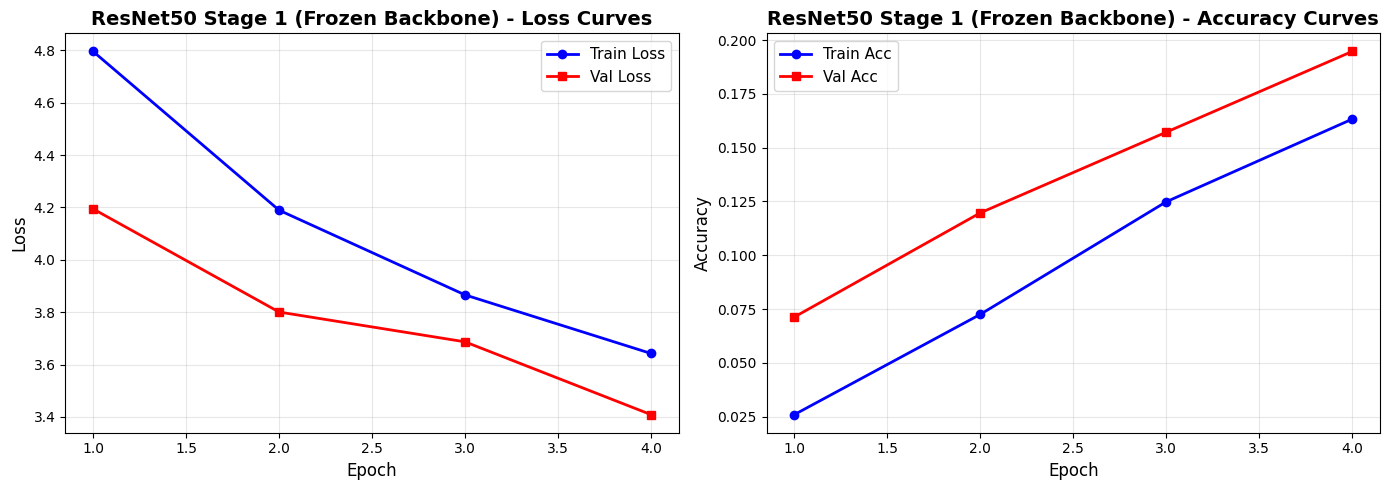


ResNet50 Stage 1 (Frozen Backbone) - Final Statistics:
  Final Train Loss: 3.6426 | Final Train Acc: 0.1632
  Final Val Loss:   3.4091 | Final Val Acc:   0.1947
  Best Val Acc:     0.1947 (Epoch 4)
  Overfitting Gap:  -0.0314


In [ ]:
print("\n" + "="*80)
print("STAGE 1: Training with Frozen Backbone")
print("="*80)

model = create_resnet50_model(num_classes=num_classes, freeze_layers=True).to(DEVICE)
# Label smoothing to reduce overfitting (smoothing=0.1 means 10% label smoothing)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

history_frozen = train_model(
    model, train_loader, val_loader, criterion, optimizer,
    scheduler, num_epochs=NUM_EPOCHS_FROZEN, device=DEVICE,
    save_path='resnet50_frozen.pt', title='ResNet50 Stage 1 (Frozen)',
    early_stopping_patience=5  # Stop if no improvement for 5 epochs
)

plot_training_history(*history_frozen, title='ResNet50 Stage 1 (Frozen Backbone)')


STAGE 2: Fine-tuning with Unfrozen Layer3 and Layer4

Creating ResNet50 model...
 Model created with frozen backbone
  - Trainable params: Classifier only (2048 -> 100)

Unfreezing last layers for fine-tuning...
✓ Unfroze layer3 and layer4 (last two residual blocks)
  - Trainable params: 22,268,004 / 23,712,932 (93.9%)

Starting training for: ResNet50 Stage 2 (Fine-tuned)

Epoch 1/15
--------------------------------------------------


Train Loss: 2.6080 | Train Acc: 0.3265
Val Loss:   1.8496 | Val Acc:   0.4933

Epoch 2/15
--------------------------------------------------


Train Loss: 1.6130 | Train Acc: 0.5722
Val Loss:   1.3891 | Val Acc:   0.6421

Epoch 3/15
--------------------------------------------------


Train Loss: 1.1853 | Train Acc: 0.6726
Val Loss:   1.0818 | Val Acc:   0.6675

Epoch 4/15
--------------------------------------------------


Train Loss: 0.8451 | Train Acc: 0.7712
Val Loss:   1.0480 | Val Acc:   0.6808

Epoch 5/15
--------------------------------------------------


Train Loss: 0.6729 | Train Acc: 0.8183
Val Loss:   0.9439 | Val Acc:   0.7304

Epoch 6/15
--------------------------------------------------


Train Loss: 0.5365 | Train Acc: 0.8540
Val Loss:   0.9225 | Val Acc:   0.7158

Epoch 7/15
--------------------------------------------------


Train Loss: 0.4570 | Train Acc: 0.8691
Val Loss:   0.8653 | Val Acc:   0.7340

Epoch 8/15
--------------------------------------------------


Train Loss: 0.3871 | Train Acc: 0.8951
Val Loss:   0.9071 | Val Acc:   0.7461

Epoch 9/15
--------------------------------------------------


Train Loss: 0.3231 | Train Acc: 0.9166
Val Loss:   0.7548 | Val Acc:   0.7678

Epoch 10/15
--------------------------------------------------


Train Loss: 0.2754 | Train Acc: 0.9293
Val Loss:   0.7945 | Val Acc:   0.7557

Epoch 11/15
--------------------------------------------------


Train Loss: 0.2687 | Train Acc: 0.9317
Val Loss:   0.8091 | Val Acc:   0.7630

Epoch 12/15
--------------------------------------------------


Train Loss: 0.2434 | Train Acc: 0.9359
Val Loss:   0.8768 | Val Acc:   0.7630
Learning rate reduced: 0.000100 -> 0.000050

Epoch 13/15
--------------------------------------------------


Train Loss: 0.1745 | Train Acc: 0.9565
Val Loss:   0.7042 | Val Acc:   0.8053

Epoch 14/15
--------------------------------------------------


Train Loss: 0.1402 | Train Acc: 0.9686
Val Loss:   0.6957 | Val Acc:   0.7969

Epoch 15/15
--------------------------------------------------


Train Loss: 0.1110 | Train Acc: 0.9767
Val Loss:   0.6737 | Val Acc:   0.8089

Training complete for ResNet50 Stage 2 (Fine-tuned)
Best validation accuracy: 0.8089



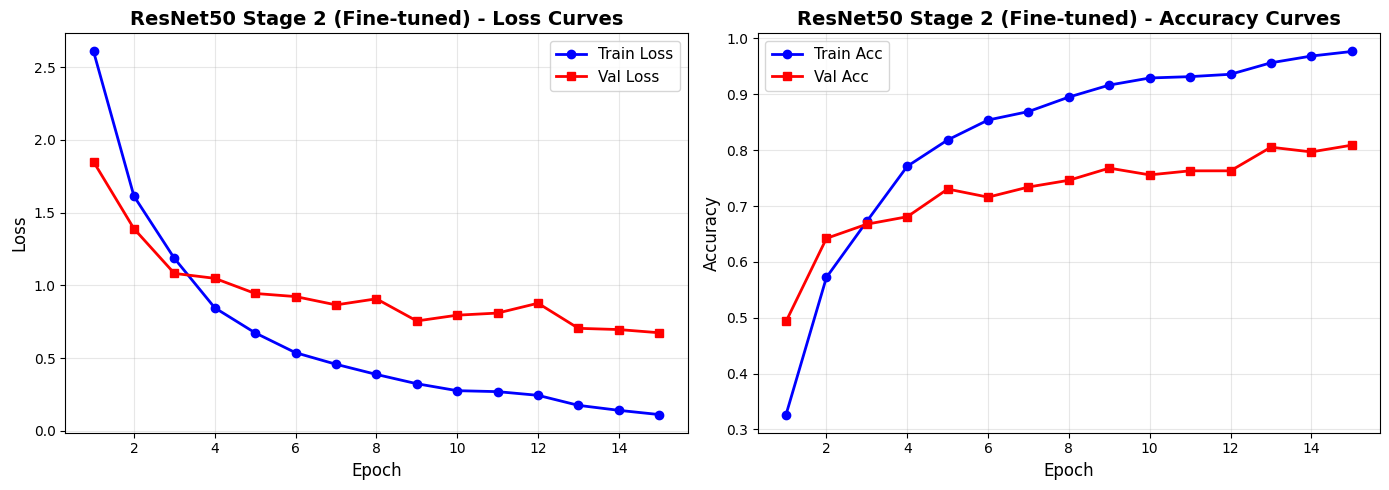


ResNet50 Stage 2 (Fine-tuned) - Final Statistics:
  Final Train Loss: 0.1110 | Final Train Acc: 0.9767
  Final Val Loss:   0.6737 | Final Val Acc:   0.8089
  Best Val Acc:     0.8089 (Epoch 15)
  Overfitting Gap:  0.1678


In [ ]:
print("\n" + "="*80)
print("STAGE 2: Fine-tuning with Unfrozen Layer3 and Layer4")
print("="*80)

# Load the best model from Stage 1
model = create_resnet50_model(num_classes=num_classes, freeze_layers=True).to(DEVICE)
model.load_state_dict(torch.load('resnet50_frozen.pt', map_location=DEVICE))

# Unfreeze layer3 and layer4
model = unfreeze_last_layers(model)

# Use lower learning rate for fine-tuning with increased weight decay
optimizer_ft = optim.AdamW([
    {"params": model.layer4.parameters(), "lr": 1e-4},
    {"params": model.layer3.parameters(), "lr": 1e-4},
    {"params": model.fc.parameters(),    "lr": 3e-4},
], weight_decay=5e-4)  # Increased from 1e-4 to 5e-4 for better regularization

# Reduce LR when validation loss plateaus
scheduler_ft = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_ft, mode='min', patience=2, factor=0.5
)

# Use label smoothing for fine-tuning as well
criterion_ft = nn.CrossEntropyLoss(label_smoothing=0.1)

history_finetuned = train_model(
    model, train_loader, val_loader, criterion_ft, optimizer_ft,
    scheduler_ft, num_epochs=NUM_EPOCHS_FINETUNE, device=DEVICE,
    save_path='resnet50_finetuned.pt', title='ResNet50 Stage 2 (Fine-tuned)',
    early_stopping_patience=5  # Stop if no improvement for 5 epochs
)

plot_training_history(*history_finetuned, title='ResNet50 Stage 2 (Fine-tuned)')


STAGE COMPARISON


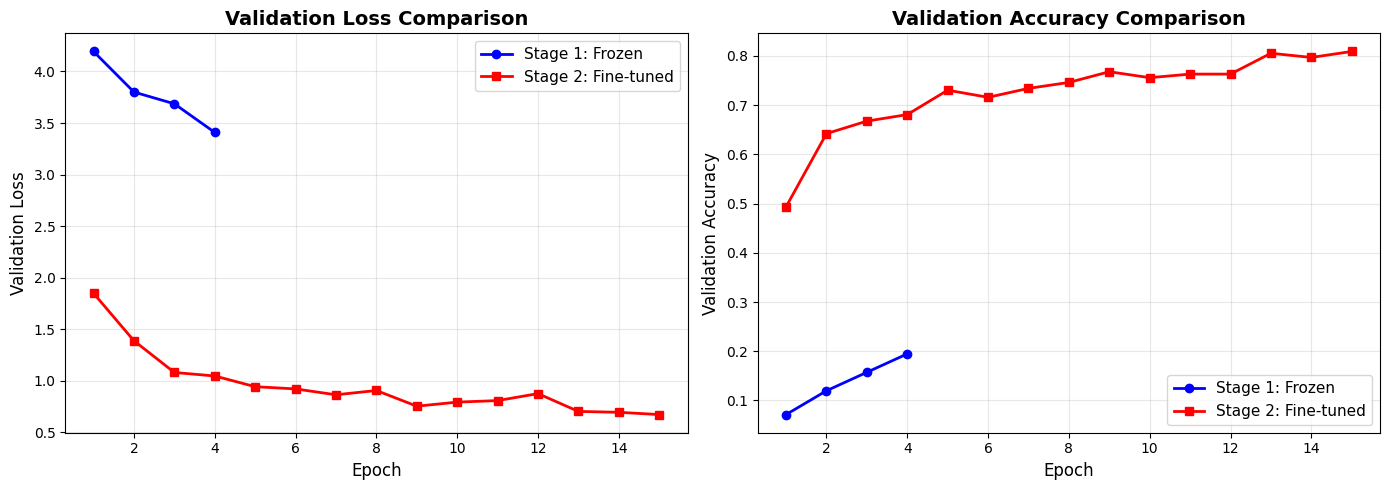


Comparison Summary:
  Stage 1 Best Val Acc: 0.1947
  Stage 2 Best Val Acc: 0.8089
  Improvement: 0.6143 (61.43%)


In [69]:
print("\n" + "="*80)
print("STAGE COMPARISON")
print("="*80)

plot_comparison(history_frozen, history_finetuned)

In [70]:
print("\n" + "="*80)
print("TRAINING COMPLETE - FINAL SUMMARY")
print("="*80)

print("\nSaved model files:")
print("  1. resnet50_frozen.pt       - After Stage 1 (frozen backbone)")
print("  2. resnet50_finetuned.pt    - After Stage 2 (fine-tuned) ← BEST MODEL")

print("\nPerformance Summary:")
print(f"  Stage 1 (Frozen):    Best Val Acc = {max(history_frozen[3]):.4f}")
print(f"  Stage 2 (Fine-tuned): Best Val Acc = {max(history_finetuned[3]):.4f}")
print(f"  Total Improvement:   +{(max(history_finetuned[3]) - max(history_frozen[3])):.4f} ({100*(max(history_finetuned[3]) - max(history_frozen[3])):.2f}%)")

print("\n" + "="*80)
print("TECHNIQUES IMPLEMENTED:")
print("="*80)
print(" Technique 1: Enhanced Data Augmentation")
print("  - Heavy augmentation with 8+ transformations")
print("  - RandomHorizontalFlip, RandomRotation(±15°)")
print("  - ColorJitter (brightness, contrast, saturation, hue)")
print("  - RandomAffine, RandomPerspective")
print("  - RandomErasing (cutout)")
print("")
print(" Technique 2: Transfer Learning")
print("  - Pre-trained ResNet50 from ImageNet")
print("  - Replaced final FC layer for 100 classes")
print("  - Frozen backbone, trained classifier only")
print("")
print(" Technique 3: Progressive Fine-tuning")
print("  - Stage 1: Train classifier with frozen backbone (10 epochs)")
print("  - Stage 2: Unfreeze layer3 + layer4 and fine-tune (5 epochs)")
print("  - Lower learning rate (1e-4) for fine-tuning")
print("  - Learning rate scheduling with ReduceLROnPlateau")

print("\n✓ Ready to generate predictions for Kaggle submission!")


TRAINING COMPLETE - FINAL SUMMARY

Saved model files:
  1. resnet50_frozen.pt       - After Stage 1 (frozen backbone)
  2. resnet50_finetuned.pt    - After Stage 2 (fine-tuned) ← BEST MODEL

Performance Summary:
  Stage 1 (Frozen):    Best Val Acc = 0.1947
  Stage 2 (Fine-tuned): Best Val Acc = 0.8089
  Total Improvement:   +0.6143 (61.43%)

TECHNIQUES IMPLEMENTED:
 Technique 1: Enhanced Data Augmentation
  - Heavy augmentation with 8+ transformations
  - RandomHorizontalFlip, RandomRotation(±15°)
  - ColorJitter (brightness, contrast, saturation, hue)
  - RandomAffine, RandomPerspective
  - RandomErasing (cutout)

 Technique 2: Transfer Learning
  - Pre-trained ResNet50 from ImageNet
  - Replaced final FC layer for 100 classes
  - Frozen backbone, trained classifier only

 Technique 3: Progressive Fine-tuning
  - Stage 1: Train classifier with frozen backbone (10 epochs)
  - Stage 2: Unfreeze layer3 + layer4 and fine-tune (5 epochs)
  - Lower learning rate (1e-4) for fine-tuning
  - 